In [1]:
import torch 
import gpytorch
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath('../..'))
from pv_plot import plot_train_test_split, plot_grid
from data.utils import *
from data import PVDataGenerator, PVDataLoader
from models import MultitaskGPModel
from kernels import Kernel
from likelihoods.beta import MultitaskBetaLikelihood
from gpytorch.means import ZeroMean, ConstantMean

In [160]:
# data parameters
DAY_INIT =310 # start of data is 01-01-2018
N_DAYS = 7 # data until 01-01-2019
DAY_MIN = 8 # starting hour of all our data (per day)
DAY_MAX = 16 # ending hour of all our data (per day)
MINUTE_INTERVAL = 5 # the minute interval of our data
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 7
N_SYSTEMS = 8
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25
N_HOURS_PRED = 2

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

==> Loading data
==> Loaded data in: 0 m : 2 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



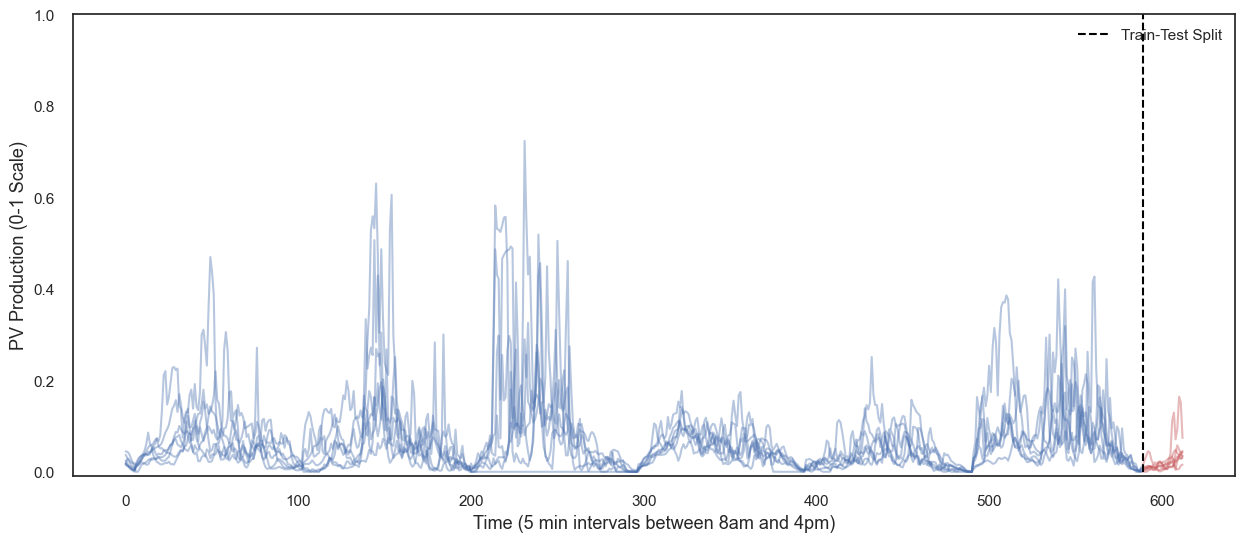

In [161]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    drop_nan=True)

X, y = generator.get_time_series()
num_latent = 4
num_tasks = y.shape[1]
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=11,n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [177]:
from kernels import get_mean_covar
from likelihoods import MultitaskBetaLikelihood

mean, covar = get_mean_covar(num_latent=num_latent)
likelihood = MultitaskBetaLikelihood(scale=20, num_tasks=num_tasks)


In [178]:
model = MultitaskGPModel(X=x_train,
                        y=y_train,
                        likelihood=likelihood,
                        mean_module=mean,
                        covar_module=covar,
                        num_latents=num_latent,
                        learn_inducing_locations=False,
                        variational_dist='cholesky',
                        jitter=1e-3,
)

In [179]:
model.fit(n_iter=100, lr=0.1, verbose=True)

Iter 10/100 - Loss: 42.889591217041016
Iter 20/100 - Loss: 36.511962890625
Iter 30/100 - Loss: 6.650644302368164
Iter 40/100 - Loss: -9.104930877685547
Iter 50/100 - Loss: -11.456759452819824
Iter 60/100 - Loss: -13.200493812561035
Iter 70/100 - Loss: -13.673095703125
Iter 80/100 - Loss: -14.111421585083008
Iter 90/100 - Loss: -14.428903579711914
Iter 100/100 - Loss: -14.675707817077637


In [180]:
median, lower, upper = model.predict(x_train, pred_type='median')

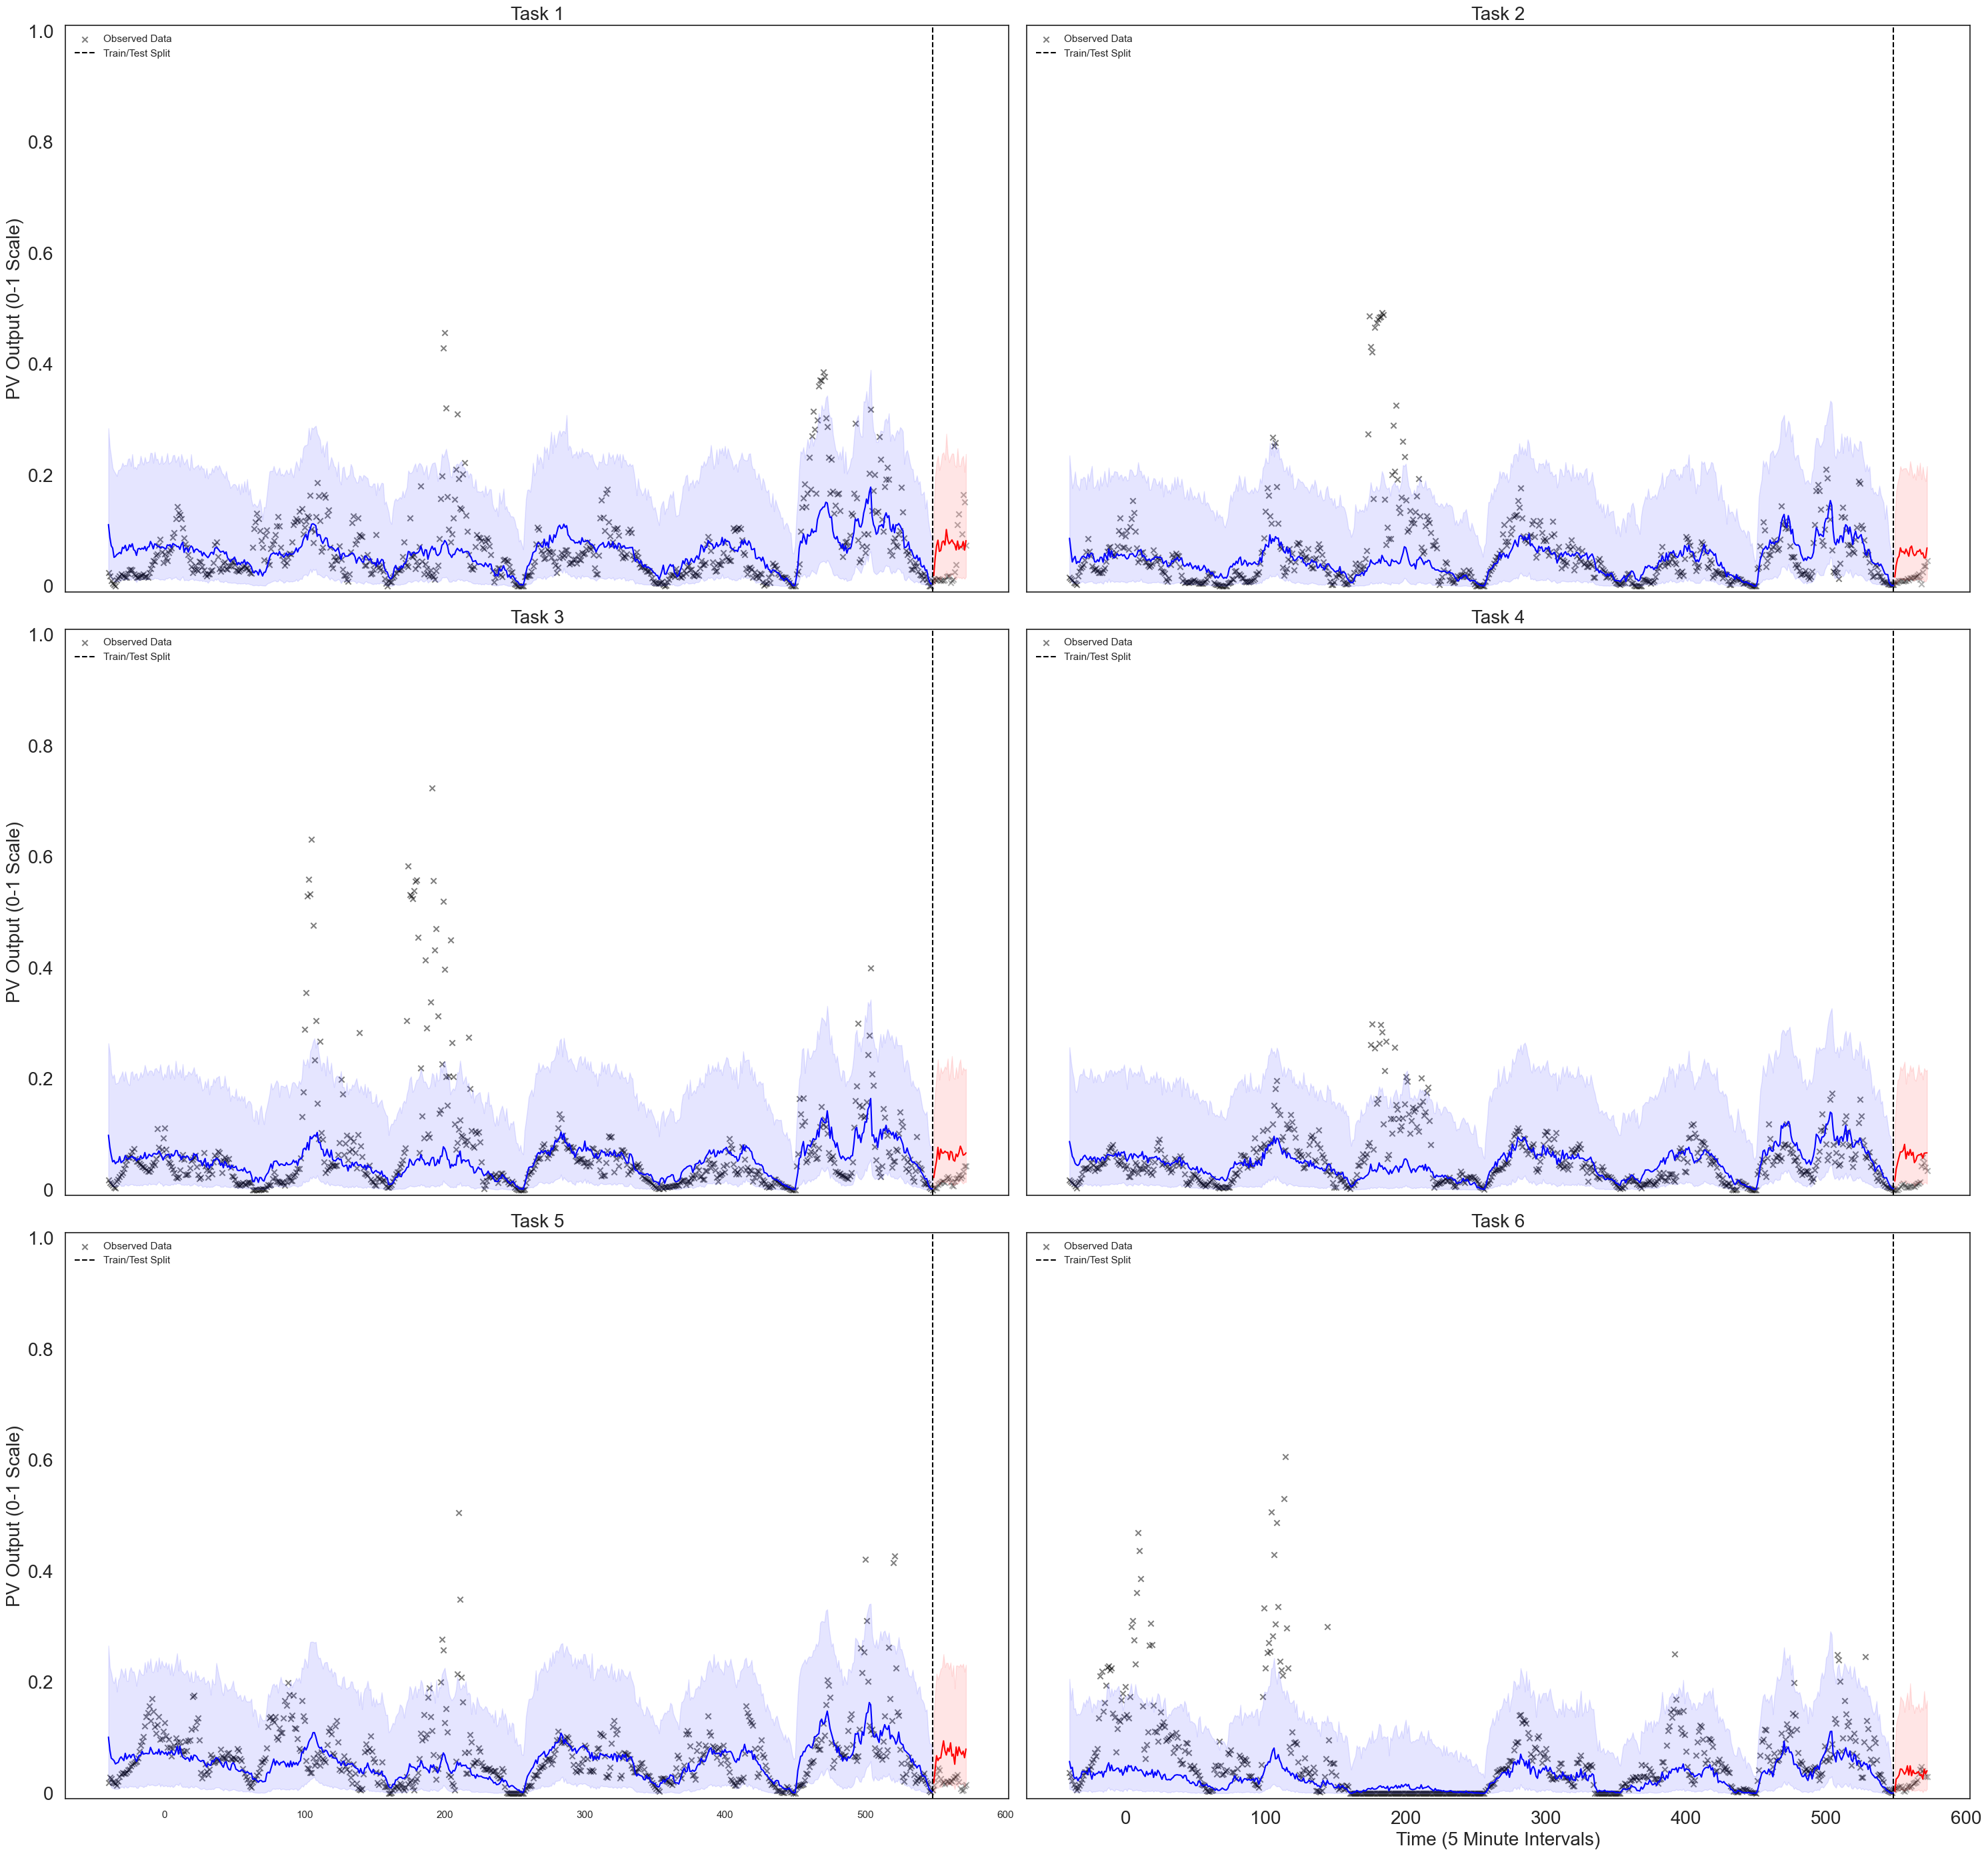

In [181]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(num_tasks // 2, 2, figsize=(30, 4 * (num_tasks)), sharex=True, sharey=True)
ax = ax.flatten()

median_tr, lower_tr, upper_tr = model.predict(x_train, pred_type='median')
median_te, lower_te, upper_te = model.predict(x_test, pred_type='median')

for i in range(len(ax)):
    ax[i].scatter(x_train, y_train[:,i], label='Observed Data', marker='x', color='black', alpha=0.5)
    ax[i].plot(x_train, median_tr[:,i],color='blue')
    ax[i].fill_between(x_train, lower_tr[:,i], upper_tr[:,i], alpha=0.1, color='blue')

    ax[i].scatter(x_test, y_test[:,i], marker='x', color='black', alpha=0.3)
    ax[i].plot(x_test, median_te[:,i],color='red')
    ax[i].fill_between(x_test, lower_te[:,i], upper_te[:,i], alpha=0.1, color='red')
    
    # plot vertical lines for train/test split
    ax[i].axvline(x_train.max(), color='black', linestyle='--', label='Train/Test Split')
    ax[i].set_ylim(-0.01, 1.01)
    ax[i].legend()
    ax[i].set_title(f'Task {i+1}', fontsize=20)

    # set ylabel for left column
    if i % 2 == 0:
        ax[i].set_ylabel('PV Output (0-1 Scale)', fontsize=20)
        ax[i].set_yticklabels([0, 0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
    
    # set xlabel for bottom row
    if i >= y.size(-1) - 2:
        ax[i].set_xlabel('Time (5 Minute Intervals)', fontsize=20)
        ax[i].set_xticklabels([0, 0, 100, 200, 300, 400, 500, 600], fontsize=20)

# remove unused axes
for i in range(y.size(-1), ax.size):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show();

In [64]:
from gpytorch.metrics import negative_log_predictive_density as nlpd

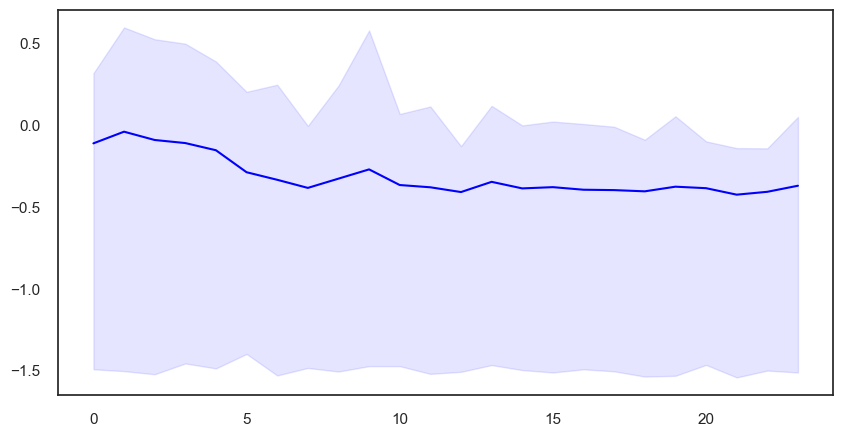

In [87]:
dist_tr = model.predict(x_train, pred_type='dist')
dist_te = model.predict(x_test, pred_type='dist')

nlpd_tr = nlpd(dist_tr, y_train).detach().numpy()
nlpd_te = nlpd(dist_te, y_test).detach().numpy()



median_nlpd = np.median(nlpd_te, axis=0)
lower_nlpd = np.quantile(nlpd_te, 0.25, axis=0)
upper_nlpd = np.quantile(nlpd_te, 0.75, axis=0)

mean_nlpd = np.mean(median_nlpd, axis=-1)
lower, upper = np.quantile(median_nlpd, [0.025, 0.975], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mean_nlpd, color='blue')
ax.fill_between(np.arange(mean_nlpd.shape[0]), lower, upper, alpha=0.1, color='blue')

In [88]:
model.likelihood.scale

tensor([[17.7610, 18.5916, 17.8976, 17.8930, 18.0718, 18.1371, 18.0723]],
       grad_fn=<SoftplusBackward0>)